In [1]:
# # 초기 1회 실행
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# 📥 데이터 다운로드 (Download Dataset)
# GitHub에서 csv 파일을 다운로드합니다.

!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_train1.csv
!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_test1.csv

--2025-06-27 15:46:48--  https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_train1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5286258 (5.0M) [text/plain]
Saving to: ‘secom_nona_train1.csv’

secom_nona_train1.c 100%[===================>]   5.04M  --.-KB/s    in 0.09s   

2025-06-27 15:46:48 (55.3 MB/s) - ‘secom_nona_train1.csv’ saved [5286258/5286258]

--2025-06-27 15:46:48--  https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_test1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

# Machine_Learning4_anomaly

In [3]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
install_and_import(['IsolationForest'])


IsolationForest is already installed.


In [4]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

# 이상치탐지

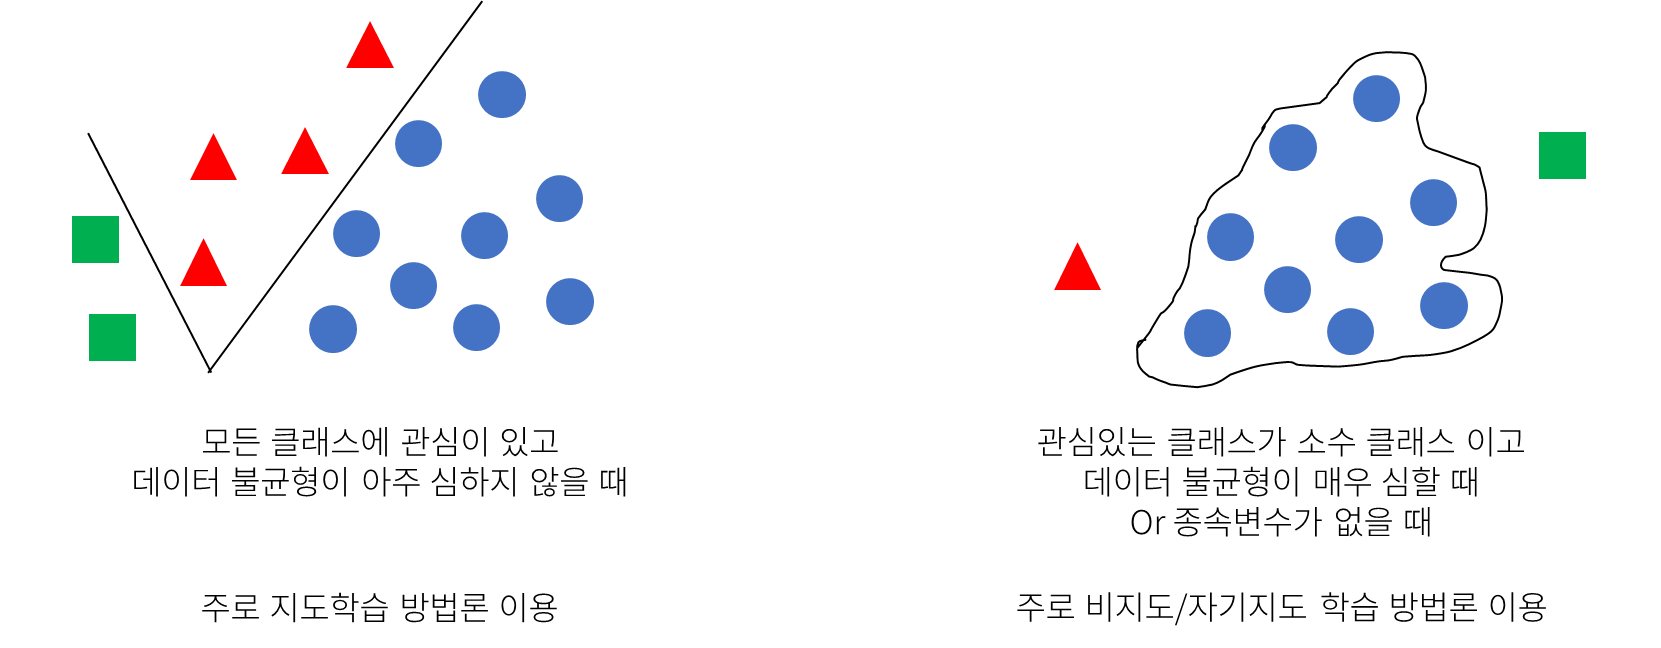

## 데이터 읽기

In [5]:
train = pd.read_csv('secom_nona_train1.csv')
test = pd.read_csv('secom_nona_test1.csv')

In [6]:
## 시간 포맷 변경
train['datetime'] = pd.to_datetime(train['datetime'], format = "%d/%m/%Y %H:%M:%S")
test['datetime'] = pd.to_datetime( test['datetime'], format = "%d/%m/%Y %H:%M:%S")

## 시간 정보 따로 저장
train_time = train['datetime']
test_time = test['datetime']

## train/test 분리
X_train = train.drop(['datetime',  'target'], axis=1)
y_train = train['target']

X_test = test.drop(['datetime', 'target'], axis=1)
y_test = test['target']

In [7]:
y_train.value_counts()

,count
target,
0,1243
1,88


## Isolation Forest

- **정상+이상 데이터로 학습하는 방법**
  - 알려진 이상치 패턴을 더 잘 탐지할 수 있음
  - 새로운 유형의 이상치에 대해서는 다소 약할 수 있음


- 정상 데이터만으로 학습하는 방법
  - 새로운 유형의 이상치 탐지에 더 강점
  - 알려진 이상치 패턴을 놓칠 수 있음


- 선택 기준
  - 데이터의 특성: 이상치의 패턴이 일관적인지, 다양한지
  - 사용 목적: 새로운 이상치 탐지가 중요한지, 알려진 이상치 탐지가 중요한지
  - 데이터 가용성: 충분한 이상치 데이터가 있는지
  - 도메인 지식: 특정 분야에서 이상치의 특성이 잘 알려져 있는지

### 기본모델

In [8]:
# from sklearn.ensemble import IsolationForest

## Isolation Forest 모델
iso_forest = IsolationForest(
                                                  n_estimators = 100,              # 트리의 수 기본값 100
                                                  max_samples = 'auto',         # 각 트리 학습에 사용할 샘플 수 (기본값: 'auto', 전체 데이터의 크기에 비례)
                                                  contamination = 88/1243,  # 이상치의 비율 기본값 "auto", 내부 threshold에 영향 미침..
                                                  max_features = 1.0,              # 각 트리 분할에 사용할 최대 특성 수 (기본값: 1.0, 전체 특성 사용)
                                                  random_state = 1,
                                                  verbose = 1,
                             )


In [9]:
## 모델 학습
iso_forest.fit(X_train) # y_train을 넣어주지 않음에 유의!


## 예측 (1은 정상, -1은 이상치)
y_pred = iso_forest.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [10]:
y_pred

array([ 1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [11]:
## 예측 결과 변환: 1은 0으로, -1은 1로 변환 (이상치를 1로 표현)
y_pred_transformed = np.where(y_pred == 1, 0, 1)

In [12]:
y_pred_transformed

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
from sklearn.metrics import confusion_matrix

def custom_confusion_matrix(y_true, y_pred):

        ## 혼동 행렬 계산
        cm = confusion_matrix(y_true=y_true,
                                                          y_pred=y_pred)
        ## 클래스 1을 기준으로 행과 열 순서 변경
        cm = cm[::-1, ::-1]

        ## 행과 열을 바꾸기 위해 전치(transpose)
        cm_transposed = cm.T
        print(cm_transposed)


        # DataFrame으로 변환 (라벨 추가)
        df_cm = pd.DataFrame(cm_transposed,
                                                      index = ['pred 1', 'pred 0'],
                                                      columns = ['act 1', 'act 0'])

        ## 히트맵 그리기
        plt.figure(figsize = (4,3))
        sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'Blues')
        plt.title('Confusion Matrix (Class 1 as Positive)')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.show()

### 기본모델 예측 결과

[[  1   8]
 [ 15 212]]


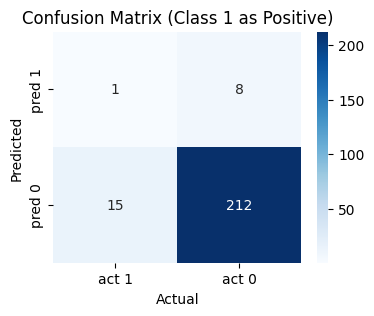

None


,0,1,accuracy,macro avg,weighted avg
precision,0.933921,0.111111,0.902542,0.522516,0.878137
recall,0.963636,0.062500,0.902542,0.513068,0.902542
f1-score,0.948546,0.080000,0.902542,0.514273,0.889661
support,220.000000,16.000000,0.902542,236.000000,236.000000


In [14]:
## 테스트 데이터에 대한 예측
print(custom_confusion_matrix(y_test, y_pred_transformed))

report = classification_report(y_test, y_pred_transformed, digits = 4,  output_dict = True)
report = pd.DataFrame(report)
report

In [15]:
f1_macro_basic = report['macro avg']['f1-score']
f1_weighted_basic = report['weighted avg']['f1-score']
recall_basic = report['macro avg']['recall']

### 하이퍼파라미터 최적화

In [16]:
from sklearn.metrics import make_scorer, f1_score

## Grid Search를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200],                 # 트리의 수
    'max_samples': [0.75, 1.0],                # 각 트리 학습에 사용할 샘플의 비율 (N > 256)
    'contamination': [0.05, 0.1, 0.2],      # 이상치로 간주할 데이터의 비율
    'max_features': [0.3, 0.6, 1.0]            # 각 트리 분할에 사용할 최대 특성 수의 비율
}

## make_scorer를 사용하여 적절한 평가 지표로 변환
# 커스텀한 스코어 함수를 GridSearchCV에서 사용할 수 있도록 변환
scorer = make_scorer(f1_score, average = 'macro')


## GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(iso_forest,
                                                          param_grid,
                                                          cv = 5,
                                                          scoring = scorer)

grid_search.fit(X_train,
                               y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Par

GridSearchCV(cv=5,
             estimator=IsolationForest(contamination=0.07079646017699115,
                                       random_state=1, verbose=1),
             param_grid={'contamination': [0.05, 0.1, 0.2],
                         'max_features': [0.3, 0.6, 1.0],
                         'max_samples': [0.75, 1.0],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro))

In [17]:
## 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:")
print(grid_search.best_params_)


## 최적의 모델로 재학습
best_model = grid_search.best_estimator_
best_model.fit(X_train)

최적의 하이퍼파라미터:
{'contamination': 0.05, 'max_features': 0.3, 'max_samples': 1.0, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


IsolationForest(contamination=0.05, max_features=0.3, max_samples=1.0,
                random_state=1, verbose=1)

### 최적 모델 예측 결과

In [18]:
## 최적의 모델로 재예측
y_best_pred = best_model.predict(X_test)


## 예측 결과 변환: 1은 0으로, -1은 1로 변환 (이상치를 1로 표현!)
y_best_pred_transformed = np.where(y_best_pred == 1, 0, 1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[[  1   5]
 [ 15 215]]


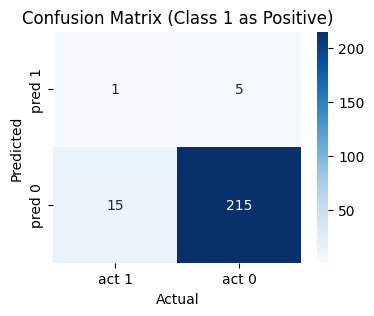

None


,0,1,accuracy,macro avg,weighted avg
precision,0.934783,0.166667,0.915254,0.550725,0.882707
recall,0.977273,0.062500,0.915254,0.519886,0.915254
f1-score,0.955556,0.090909,0.915254,0.523232,0.896935
support,220.000000,16.000000,0.915254,236.000000,236.000000


In [19]:
## 테스트 데이터에 대한 예측
print(custom_confusion_matrix(y_test, y_best_pred_transformed))

report = classification_report(y_test, y_best_pred_transformed, digits = 4,  output_dict = True)
report = pd.DataFrame(report)
report

In [20]:
f1_macro_best = report['macro avg']['f1-score']
f1_weighted_best = report['weighted avg']['f1-score']
recall_best = report['macro avg']['recall']

### 이상치 점수

- 논문상 이상치 점수

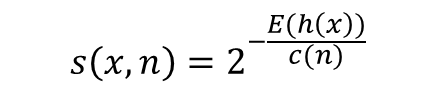

- 실제 구현과 논문상 스코어의 차이..
   - 스케일링: scikit-learn의 구현은 이 점수를 -1에서 1 사이로 스케일링
   - score = -1 * (original_score - 0.5) * 2
   - 낮은 값이 이상치를 나타내도록 부호를 반전시킴...
   - 만약 논문의 점수로 바꾸고 싶다면..
     - (0.5 - score / 2)를 적용

- c(n):  iso_forest.offset_

#### 구현의 이상치 점수

In [21]:
## 이상치 점수 계산
## anomaly_scores_raw = best_model.score_samples(X_test)  # 원시 이상치 점수, 원래 고립 경로 길이(path length)로 사용안함
anomaly_scores_normalized = best_model.decision_function(X_test) # 내부적으로 offset_이라는 정규화 기준을 사용해 조정된 값, 이것을 이상치점수로 사용!!
anomaly_scores_normalized[:10] # 음수: 이상치, 양수: 정상

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([ 0.03821075,  0.03434739,  0.03709771, -0.00183287,  0.03678709,
        0.03187989,  0.02063979,  0.02357163,  0.02595763,  0.03852166])

In [22]:
anomaly_scores = anomaly_scores_normalized

Text(0, 0.5, 'Anomaly Score')

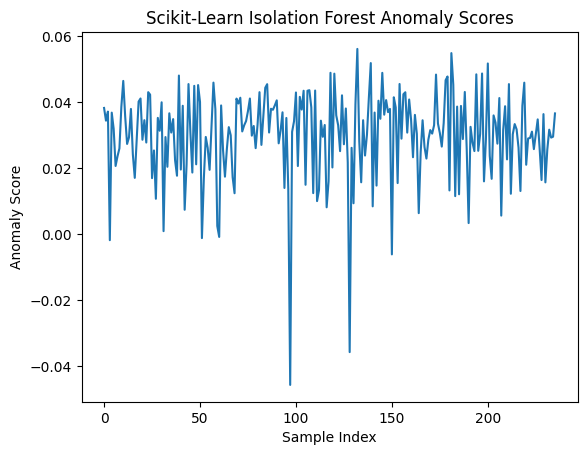

In [23]:
plt.plot(anomaly_scores) ## 값이 작을 수록 이상치일 가능성이 높음!
plt.title("Scikit-Learn Isolation Forest Anomaly Scores")
plt.xlabel("Sample Index")
plt.ylabel("Anomaly Score")

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  2.,  1.,  1.,  2.,
         3.,  3.,  8.,  4., 12.,  2.,  9.,  5., 10., 17., 17., 21., 14.,
        15., 16., 18., 15., 12., 10.,  3.,  7.,  2.,  0.,  2.]),
 array([-0.04566014, -0.04362534, -0.04159054, -0.03955574, -0.03752094,
        -0.03548614, -0.03345134, -0.03141654, -0.02938174, -0.02734694,
        -0.02531214, -0.02327734, -0.02124254, -0.01920774, -0.01717294,
        -0.01513814, -0.01310334, -0.01106854, -0.00903374, -0.00699894,
        -0.00496414, -0.00292934, -0.00089454,  0.00114026,  0.00317506,
         0.00520985,  0.00724465,  0.00927945,  0.01131425,  0.01334905,
         0.01538385,  0.01741865,  0.01945345,  0.02148825,  0.02352305,
         0.02555785,  0.02759265,  0.02962745,  0.03166225,  0.03369705,
         0.03573185,  0.03776665,  0.03980145,  0.04183625,  0.04387105,
         0.04590585,  0.04794065,  0.04997545,  0.05201025,

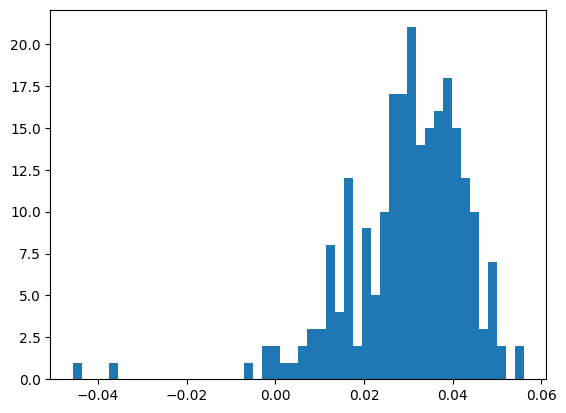

In [24]:
## anomaly score 분포
plt.hist(anomaly_scores, bins = 50)

#### 오리지날 이상치 점수

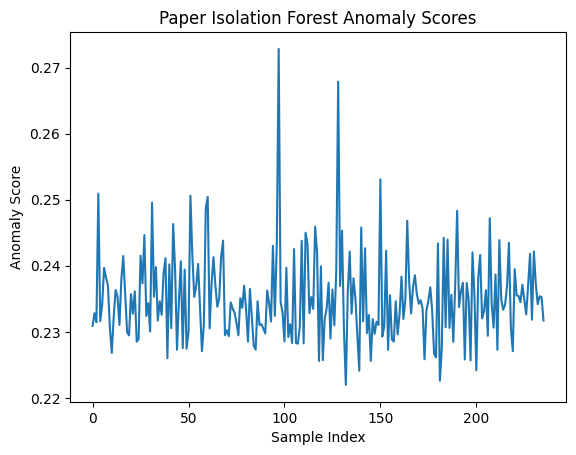

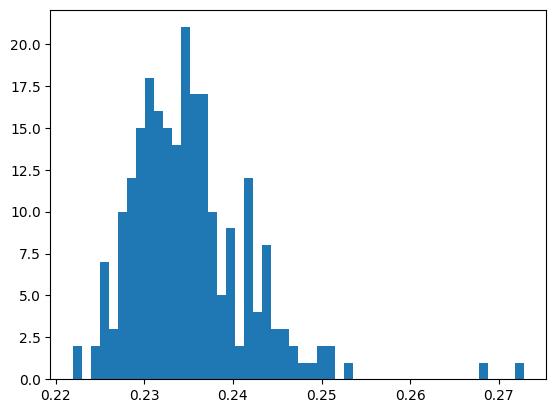

In [25]:
## 참고: 오리지날 이상치 점수(paper에 나온 score) 계산
original_anomaly_score = (0.5 - anomaly_scores)/2
original_anomaly_score

plt.plot(original_anomaly_score) ## 1에 가까울 수록 이상치일 가능성이 높음!!
plt.title("Paper Isolation Forest Anomaly Scores")
plt.xlabel("Sample Index")
plt.ylabel("Anomaly Score")
plt.show()

## or iginal_anomaly_score 분포
plt.hist(original_anomaly_score, bins = 50)
plt.show()


### Threshold

- 임의의 threshold에 대한 결과 확인
- contamination 비율로 조절 vs manually 선택

In [26]:
###  threshold 선택하기
# threshold = np.percentile(anomaly_scores, ( 88/1243 )*100) # contamination 이용했을 경우
threshold = 0.0191415 # Select a random value
threshold

0.0191415

In [27]:
## 임계값을 기준으로 값 변환: threshold보다 작으면 1, 크거나 같으면 0으로 변환
converted_anomaly_scores = np.where(anomaly_scores < threshold, 1, 0)
converted_anomaly_scores

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

[[  5  38]
 [ 11 182]]


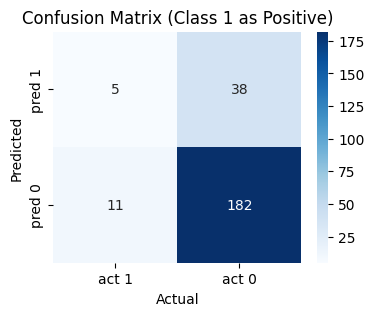

None


,0,1,accuracy,macro avg,weighted avg
precision,0.943005,0.116279,0.792373,0.529642,0.886956
recall,0.827273,0.312500,0.792373,0.569886,0.792373
f1-score,0.881356,0.169492,0.792373,0.525424,0.833094
support,220.000000,16.000000,0.792373,236.000000,236.000000


In [28]:
## 테스트 데이터에 대한 예측
print(custom_confusion_matrix(y_test, converted_anomaly_scores))

report = classification_report(y_test, converted_anomaly_scores, digits = 4,  output_dict = True)
report = pd.DataFrame(report)
report

In [29]:
f1_macro_thres = report['macro avg']['f1-score']
f1_weighted_thres = report['weighted avg']['f1-score']
recall_thres = report['macro avg']['recall']

In [30]:
compare_df = pd.DataFrame(
    {
    'model' : ['basic', 'best',  'threshold'],
    'f1_macro' : [f1_macro_basic, f1_macro_best, f1_macro_thres],
    'f1_weighted' : [f1_weighted_basic, f1_weighted_best,  f1_weighted_thres],
    'recall' : [recall_basic, recall_best, recall_thres]
    }
)
compare_df


,model,f1_macro,f1_weighted,recall
0,basic,0.514273,0.889661,0.513068
1,best,0.523232,0.896935,0.519886
2,threshold,0.525424,0.833094,0.569886


## 참고: iForest에서 정상데이터만 가지고 학습하는 방법
- **정상 데이터만으로 학습하는 방법**
  - 새로운 유형의 이상치 탐지에 더 강점
  - 알려진 이상치 패턴을 놓칠 수 있음
- 정상+이상 데이터로 학습하는 방법
  - 알려진 이상치 패턴을 더 잘 탐지할 수 있음
  - 새로운 유형의 이상치에 대해서는 다소 약할 수 있음

- 선택 기준
  - 데이터의 특성: 이상치의 패턴이 일관적인지, 다양한지
  - 사용 목적: 새로운 이상치 탐지가 중요한지, 알려진 이상치 탐지가 중요한지
  - 데이터 가용성: 충분한 이상치 데이터가 있는지
  - 도메인 지식: 특정 분야에서 이상치의 특성이 잘 알려져 있는지



### train에서 정상 데이터만 추출

In [31]:
## train에서 정상 데이터만 추출
X_train_normal = X_train[y_train == 0]
X_train_normal

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589
0,3068.67,2517.04,2258.2778,2073.0764,1.2329,100.0,96.9478,0.1208,1.3524,0.0020,...,0.00694,138.68936,0.5024,0.0210,0.0045,4.1720,0.0276,0.0160,0.0053,57.7824
1,2995.73,2515.83,2231.6111,2005.8966,1.2969,100.0,93.7522,0.1234,1.4136,0.0129,...,0.00470,183.39280,0.5011,0.0103,0.0027,2.0617,0.0090,0.0166,0.0047,183.3928
2,2953.63,2384.04,2191.2111,1437.5003,2.2073,100.0,97.6444,0.1235,1.3584,-0.0024,...,0.00564,132.99172,0.4968,0.0188,0.0041,3.7853,0.0137,0.0326,0.0108,237.4625
3,3043.70,2535.71,2127.9555,1011.1924,1.0863,100.0,107.1522,0.1261,1.4221,-0.0098,...,0.00460,78.16162,0.4948,0.0124,0.0030,2.5147,0.0215,0.0071,0.0027,33.1090
4,2971.93,2557.58,2189.8778,1158.0925,1.5291,100.0,107.8200,0.1219,1.5361,0.0188,...,0.00460,64.53566,0.4965,0.0217,0.0047,4.3766,0.0419,0.0098,0.0032,23.3852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,2929.93,2517.50,2218.8778,1188.2630,1.2557,100.0,100.9444,0.1212,1.5189,-0.0090,...,0.01500,93.51340,0.4999,0.0098,0.0029,1.9702,0.0429,0.0401,0.0150,93.5134
1327,3142.21,2389.91,2223.5333,1352.1869,0.8714,100.0,97.2189,0.1196,1.3465,-0.0054,...,0.00624,60.40976,0.5037,0.0252,0.0056,4.9959,0.0091,0.0169,0.0047,185.8369
1328,3110.23,2397.92,2184.8889,905.1501,1.3378,100.0,106.6900,0.1226,1.4349,0.0062,...,0.00608,316.60016,0.4934,0.0126,0.0030,2.5513,0.0274,0.0072,0.0019,26.1430
1329,3047.19,2524.18,2197.3111,969.8910,1.3015,100.0,105.3911,0.1201,1.5837,-0.0266,...,0.00568,121.25854,0.4967,0.0113,0.0034,2.2808,0.0082,0.0162,0.0054,197.9951


### 모델링

In [32]:
# from sklearn.ensemble import IsolationForest

## Isolation Forest 모델
iso_forest_normal = IsolationForest(
                                                      n_estimators = 100,              # 트리의 수 기본값 100
                                                      max_samples = 'auto',         # 각 트리 학습에 사용할 샘플 수 (기본값: 'auto', 전체 데이터의 크기에 비례)
                                                      # contamination = 88/1243,  # 이상치의 비율 기본값 "auto", 모른다고 가정하고
                                                      max_features = 0.3,              # 각 트리 분할에 사용할 최대 특성 수 (기본값: 1.0, 전체 특성 사용)
                                                      random_state = 1,
                                                      verbose = 1,

                             )



## 정상 데이터만으로  모델 학습
iso_forest_normal.fit(X_train_normal)


## 예측 (1은 정상, -1은 이상치)
y_pred_normal = iso_forest_normal.predict(X_train_normal)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [33]:
pd.Series(y_pred_normal).value_counts() ## 정상만 학습했지만, 이상치로도 분류가 됨

,count
1,1241
-1,2


In [34]:
## train 데이터에 대해서 적용
y_pred_score_train = iso_forest_normal.decision_function(X_train_normal)
y_pred_score_train

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([0.09344859, 0.11170059, 0.07030918, ..., 0.10148991, 0.11625548,
       0.09576394])

In [35]:
## Threshold 후보들
threshold_per = np.percentile(y_pred_score_train, 1) # 하위 1% 값
threshold_min = np.min(y_pred_score_train) # 최소값
threshold_per,  threshold_min

(np.float64(0.03314165394233394), np.float64(-0.018954097495395783))

(array([  1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   1.,   3.,   1.,   4.,   0.,   1.,   4.,   3.,   6.,   3.,
          4.,   4.,   7.,  10.,  17.,  22.,  27.,  32.,  43.,  57.,  53.,
         67.,  90., 122., 113.,  96.,  92.,  91.,  93.,  51.,  49.,  28.,
         24.,   7.,  10.,   2.,   1.,   1.]),
 array([-0.0189541 , -0.01584789, -0.01274169, -0.00963549, -0.00652928,
        -0.00342308, -0.00031688,  0.00278933,  0.00589553,  0.00900173,
         0.01210794,  0.01521414,  0.01832034,  0.02142655,  0.02453275,
         0.02763895,  0.03074516,  0.03385136,  0.03695756,  0.04006377,
         0.04316997,  0.04627617,  0.04938238,  0.05248858,  0.05559478,
         0.05870099,  0.06180719,  0.06491339,  0.0680196 ,  0.0711258 ,
         0.074232  ,  0.07733821,  0.08044441,  0.08355061,  0.08665682,
         0.08976302,  0.09286922,  0.09597543,  0.09908163,  0.10218783,
         0.10529404,  0.10840024,  0.11150644,  0.11461265,  0.11771885,
 

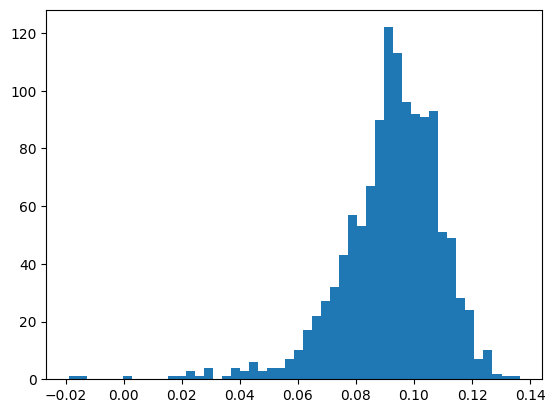

In [36]:
## anomaly score 분포
plt.hist(y_pred_score_train, bins = 50)

### test 데이터 적용

In [37]:
## test 데이터에 대해서 적용
y_pred_test = iso_forest_normal.decision_function(X_test)
y_pred_test

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([0.10954412, 0.08544936, 0.09192171, 0.07120475, 0.09114404,
       0.09209726, 0.07549583, 0.07686333, 0.07679142, 0.09578567,
       0.1095399 , 0.09654094, 0.08688911, 0.0796243 , 0.10728606,
       0.08261956, 0.08958103, 0.07211904, 0.07252179, 0.09949308,
       0.0886513 , 0.09044778, 0.09027069, 0.11117674, 0.10040003,
       0.07289158, 0.08904207, 0.06974827, 0.09112183, 0.0924547 ,
       0.11189672, 0.0729183 , 0.09322309, 0.06749939, 0.10670164,
       0.07807327, 0.09727726, 0.10347843, 0.08184531, 0.11153226,
       0.07945891, 0.11453731, 0.07646593, 0.08323003, 0.1059127 ,
       0.09215931, 0.08988589, 0.10443786, 0.08864446, 0.10857228,
       0.10577871, 0.06971611, 0.05875811, 0.065465  , 0.10728491,
       0.08057207, 0.09668468, 0.09768711, 0.11425371, 0.07698773,
       0.07275818, 0.08493085, 0.09974517, 0.10331717, 0.08773235,
       0.0865709 , 0.11727316, 0.08012771, 0.10162903, 0.1007824 ,
       0.10617052, 0.10831765, 0.09793375, 0.06623642, 0.11256

### 모델 평가

In [38]:
## 1. threshold_per 기준으로 이상치 탐지해보기
y_pred_anomaly_per = np.where(y_pred_test < threshold_per, 1, 0)

## 2. threshold_min 기준으로 이상치 탐지해보기
y_pred_anomaly_min = np.where(y_pred_test < threshold_min, 1, 0)

In [39]:
### 모델 평가1
report_per = classification_report(y_test, y_pred_anomaly_per, digits = 4,  output_dict = True)
report_per = pd.DataFrame(report_per)

f1_macro_per = report_per['macro avg']['f1-score']
f1_weighted_per = report_per['weighted avg']['f1-score']
recall_per = report_per['macro avg']['recall']

report_per

,0,1,accuracy,macro avg,weighted avg
precision,0.935897,0.500000,0.932203,0.717949,0.906345
recall,0.995455,0.062500,0.932203,0.528977,0.932203
f1-score,0.964758,0.111111,0.932203,0.537934,0.906883
support,220.000000,16.000000,0.932203,236.000000,236.000000


In [40]:
###모델 평가2
report_min = classification_report(y_test, y_pred_anomaly_min, digits = 4,  output_dict = True)
report_min = pd.DataFrame(report_min)

f1_macro_min = report_min['macro avg']['f1-score']
f1_weighted_min = report_min['weighted avg']['f1-score']
recall_min = report_min['macro avg']['recall']

report_min

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.932203,0.0,0.932203,0.466102,0.869003
recall,1.000000,0.0,0.932203,0.500000,0.932203
f1-score,0.964912,0.0,0.932203,0.482456,0.899494
support,220.000000,16.0,0.932203,236.000000,236.000000


In [41]:
compare_df2 = pd.DataFrame(
    {
    'model' : [
               'basic',
               'best',
               'threshold',
               'normal_only_per',
               'normal_only_min'],
    'f1_macro' : [
                  f1_macro_basic,
                  f1_macro_best,
                  f1_macro_thres,
                  f1_macro_per,
                  f1_macro_min],
    'f1_weighted' : [
                    f1_weighted_basic,
                     f1_weighted_best,
                     f1_weighted_thres,
                     f1_weighted_per,
                     f1_weighted_min],
    'recall' : [
                recall_basic,
                recall_best,
                recall_thres,
                recall_per,
                recall_min]
    }
)
compare_df2


,model,f1_macro,f1_weighted,recall
0,basic,0.514273,0.889661,0.513068
1,best,0.523232,0.896935,0.519886
2,threshold,0.525424,0.833094,0.569886
3,normal_only_per,0.537934,0.906883,0.528977
4,normal_only_min,0.482456,0.899494,0.500000


In [42]:
# EOS